## Imports

In [7]:
!pip install "deeplake<4"

  Using cached deeplake-3.9.52-py3-none-any.whl
  Using cached pillow-10.4.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached humbug-0.3.2-py3-none-any.whl.metadata (6.8 kB)
  Using cached lz4-4.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached aioboto3-15.2.0-py3-none-any.whl.metadata (8.9 kB)
  Using cached libdeeplake-0.0.164-cp311-cp311-manylinux2014_x86_64.whl.metadata (479 bytes)
  Using cached aiobotocore-2.24.2-py3-none-any.whl.metadata (25 kB)
  Using cached aiofiles-25.1.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached aioitertools-0.12.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached botocore-1.40.18-py3-none-any.whl.metadata (5.7 kB)
  Using cached boto3-1.40.18-py3-none-any.whl.metadata (6.7 kB)
  Using cached s3transfer-0.13.1-py3-none-any.whl.metadata (1.7 kB)
Using cached aioboto3-15.2.0-py3-none-any.whl (35 kB)
Using cached aiobotoc

In [8]:
import deeplake
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import ConcatDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.3.5) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


### Loading Repo

In [2]:
!git clone -b talib-1 http://github.com/Zapy67/ATML-PA-2

Cloning into 'ATML-PA-2'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 271 (delta 143), reused 201 (delta 79), pack-reused 0 (from 0)
Receiving objects: 100% (271/271), 2.58 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [ ]:
!git pull http://github.com/Zapy67/ATML-PA-2 talib-1

In [3]:
%cd ATML-PA-2/"DANN & CDAN"

/kaggle/working/ATML-PA-2/DANN & CDAN


In [4]:
!ls

cdan.ipynb  CDAN.py  dann.ipynb  DANN.py  train.py  utils


In [5]:
from utils.dataset import MEAN, STD, DeepLakeWrapper

### Loading Dataset using DeepLake

In [9]:
ds = deeplake.load("hub://activeloop/office-home-domain-adaptation")

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/office-home-domain-adaptation



\

hub://activeloop/office-home-domain-adaptation loaded successfully.



In [10]:
domain_map = {0: "RealWorld", 1: "Product", 2: "Art", 3: "Clipart"} # For reference

def filter_by_domain(ds, domain_id):
    """Return a Deep Lake subset for a specific domain."""
    return ds.filter(lambda x: int(x['domain_categories'].numpy()[0]) == domain_id)
    
art_ds = filter_by_domain(ds, 2)
clipart_ds = filter_by_domain(ds, 3)
product_ds = filter_by_domain(ds, 1)
real_ds = filter_by_domain(ds, 0)

100%|██████████| 15588/15588 [00:01<00:00, 11857.88it/s]


In [11]:
art_torch = DeepLakeWrapper(art_ds, domain_label=2)
product_torch = DeepLakeWrapper(product_ds, domain_label=1)
real_torch = DeepLakeWrapper(real_ds, domain_label=0)
clipart_torch = DeepLakeWrapper(clipart_ds, domain_label=3)

In [12]:
source_ds = ConcatDataset([art_torch, product_torch, real_torch])
target_ds = clipart_torch

In [13]:
source_loader = DataLoader(source_ds, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_ds, batch_size=32, shuffle=True, num_workers=2)

In [14]:
def denormalize_batch(imgs_tensor, mean=MEAN, std=STD):
    """Imgs: Tensor (N, C, H, W) normalized. Returns uint8 numpy (N, H, W, C)."""
    imgs = imgs_tensor.detach().cpu().clone()
    # imgs * std + mean  (per-channel)
    for t, m, s in zip(imgs, mean, std):
        t.mul_(s).add_(m)
    imgs = imgs.permute(0, 2, 3, 1).numpy()  # N,H,W,C with floats in [0,1] (roughly)
    imgs = (imgs * 255.0).clip(0, 255).astype(np.uint8)
    return imgs

In [15]:
def show_images(imgs, labels=None, domains=None, title="Batch", max_images=8, class_map=None, domain_map=None):
    imgs_np = denormalize_batch(imgs)  # returns floats [0,1]
    n = min(max_images, len(imgs_np))
    cols = min(8, n)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs_np[i])
        lbl = ""
        if labels is not None:
            lab = labels[i].item() if hasattr(labels[i], "item") else int(labels[i])
            if class_map is not None:
                lbl += f"{class_map.get(lab, lab)}"
            else:
                lbl += f"Class: {lab}"
        if domains is not None:
            d = domains[i].item() if hasattr(domains[i], "item") else int(domains[i])
            dname = domain_map.get(d, d) if domain_map is not None else d
            lbl += f"\nDomain: {dname}"
        plt.title(lbl, fontsize=9)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


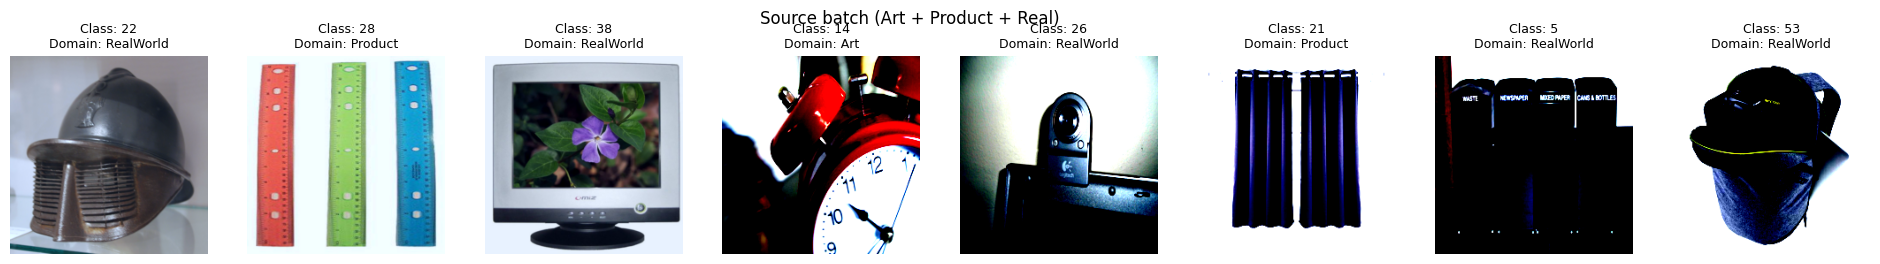

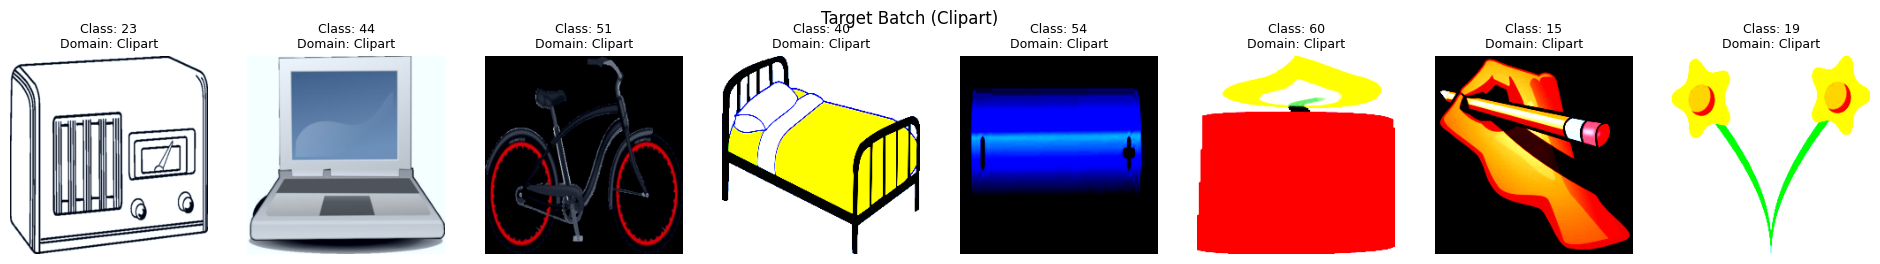

In [16]:
imgs, labels, domains = next(iter(source_loader))
t_imgs, t_labels, t_domains = next(iter(target_loader))

# show source images
show_images(imgs, labels, domains, title="Source batch (Art + Product + Real)", max_images=8, domain_map=domain_map)
# show target images
show_images(t_imgs, t_labels, t_domains, title="Target Batch (Clipart)", max_images=8, domain_map=domain_map)

## DANN Training

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import DANN as dann

In [25]:
np.unique(ds["domain_objects"].numpy())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64],
      dtype=uint32)

In [ ]:
model = dann.DANN(num_classes=65)

In [ ]:
trainer = dann.DANNTrainer(
        model=model,
        device=device,
        learning_rate=1e-3,
        weight_decay=1e-4,
        gamma=10.0
    )

In [ ]:
trainer.train(source_loader=source_loader, target_loader=target_loader, num_epochs=10)